In [1]:
# Importing
# This will likely produce some ignorable warnings
%load_ext autoreload
%autoreload 2

import sys  
sys.path.insert(0, '/home/ryan/zdc_commits/regressiononly/functions')
from plotting import *
from data_functions import *
import pandas as pd
import numpy as np
import compress_pickle as pickle  
import mplhep as hep
import uproot
hep.style.use("CMS")

/home/ryan/.local/lib/python3.8/site-packages/awkward0/__init__.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(numpy.__version__) < distutils.version.LooseVersion("1.13.1"):
2024-04-03 13:59:57.692567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 13:59:58.201340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Using variable strings ['E', 'X', 'Y', 'Z'] from binning_utils.py



### Opening the ML model results

In [2]:
# Conditions to open the desired ML results
file_conditions = {
    # Model trained only on photon data
    ('zdc', 'gamma', 'graphnet', '4D', '2D', '64Fe',  'h4', False, '.5', '.5', False, None, None):{
    'result_dir': '/home/ryan/zdc_studies/results/results_4D_output2D_zdc_gamma_graphnet_energy0.5_theta0.5/ECCE_20231214-2004_graphnet_4D/',
    'preprocessed_dir': '/home/ryan/zdc_studies/preprocessed/preprocessed_input4D_output2D_zdc_gamma_graphnet',
    'discrete_data':'/media/miguel/Elements/zdc_data/zdc_gamma_log10discrete_10_300GeV_0-0.23deg_staggered_h4_11_23/',
    'num_discrete_files' : 100, 
    'continuous_data': '/media/miguel/Elements/zdc_data/zdc_gamma_log10continuous_10_300GeV_0-0.23deg_staggered_h4_11_23/',
    'num_continuous_files ':  118, 
    },
    # Model for pi0/gamma classification
    ('zdc', 'pi0_gamma', 'graphnet', '4D', '2D', '64Fe',  'h4', False, '.5', '.5', True, '.75', '.25'):{
    'result_dir': '/home/ryan/zdc_studies/results/pi0_gamma_classifcation_results_regress0.75_class0.25_energy0.5_theta0.5_num1/ECCE_20240110-1704_graphnet_4D/',
    'preprocessed_dir': '/home/ryan/zdc_studies/preprocessed/pi0_gamma_classifcation_preprocessed_equalnum_gammapi0',
    'discrete_data':'/media/miguel/Elements/zdc_data/classification_data/zdc_photon_pion0_log10discrete_10GeV-300GeV-0.0deg-0.23deg_staggered_h4_11_2023/',
    'num_discrete_files' : 169, 
    'continuous_data': '/media/miguel/Elements/zdc_data/classification_data/zdc_photon_pion0_log10continuous_10GeV-300GeV-0.0deg-0.23deg_staggered_h4_11_2023/',
    'num_continuous_files ':  266, 
    }
}

default_entry = {
    'result_dir': 'No_File',
    'preprocessed_dir': 'No_Title',
}


In [3]:
# Insert your conditions from your config file below

detector='zdc'   ## insert, hcal, zdc, 
particle ='pi0_gamma'  # pi+,  pi0, neutron, gamma
model='graphnet'  ## graphnet, DeepSets
input_features='4D'  ## input features [4D, 2D, 1D]
output_dim='2D'    ## '1D' or '2D'
absorber='64Fe' ## Depends on detector
readout='h4' ## None for hcal , insert But for ZDC: h4, h3, unstaggered
include_ecal=False ## False (ZDC it should be False rest True uncless only HCAL data is taken)
energy_weight='.5' ## 'None' if no energy weight is used
theta_weight='.5' ## 'None' if no theta weight is used
classification=True 
regression_weight='.75' # 'None' if no regression weight is used (i.e. classification == False)
classification_weight='.25'# 'None' if no classification weight is used (i.e. classification == False)
entry = file_conditions.get((detector,
                             particle,
                             model,
                             input_features,
                             output_dim, absorber,
                             readout,
                             include_ecal,
                             energy_weight,
                             theta_weight,
                             classification,
                             regression_weight,
                             classification_weight), default_entry)
path_to_result = entry['result_dir']
path_to_stat = entry['preprocessed_dir']

if entry['result_dir'] == 'No_File':
    print('File not found')    

print(path_to_result)  

/home/ryan/zdc_studies/results/pi0_gamma_classifcation_results_regress0.75_class0.25_energy0.5_theta0.5_num1/ECCE_20240110-1704_graphnet_4D/


## Get predicted and target variable


In [4]:
npz_unpacked = np.load(path_to_result+"/predictions_appended_test.npz")  
predictions_2 = npz_unpacked['outputs_scaled']
targets_2 = npz_unpacked['targets_scaled']
targets = npz_unpacked['targets']
predictions = npz_unpacked['outputs']

# Obtaining the file names and event numbers for each entry
meta_info_initial = npz_unpacked['meta']
meta_info =[]
# The saved meta is in the form of [file_name, event_num, file_name, event_num, ...]
# Put it in the form [(file_name, event_num), (file_name, event_num), ...]
# This aligns its length with the lengths of targets and predictions
for i, element in enumerate(meta_info_initial):
    if i%2 == 0:
        file_name = meta_info_initial[i]
        event_num = int(meta_info_initial[i+1])
        meta_tuple = (file_name, event_num) # putting the file names and event numbers into a tuple
        meta_info.append(meta_tuple)
    else:
        continue
meta_info = np.asarray(meta_info, dtype='object,int') # Data type for each entry is (string, int), i.e. (object, int)

# Reading targets and predictions from model

if output_dim=='2D': # Energy and theta
    targets_ene = targets_2[:,0]
    targets_theta = targets_2[:,1]

    predictions_ene=predictions_2[:,0]
    predictions_theta=predictions_2[:,1]
elif output_dim =='1D': # Only energy
    targets_ene = targets_2
    predictions_ene=predictions_2
if classification: # Getting the classification results if using them
    targets_particle = targets[:,-1]
    predictions_particle = predictions[:,-1]

## Inspect the Loss curve

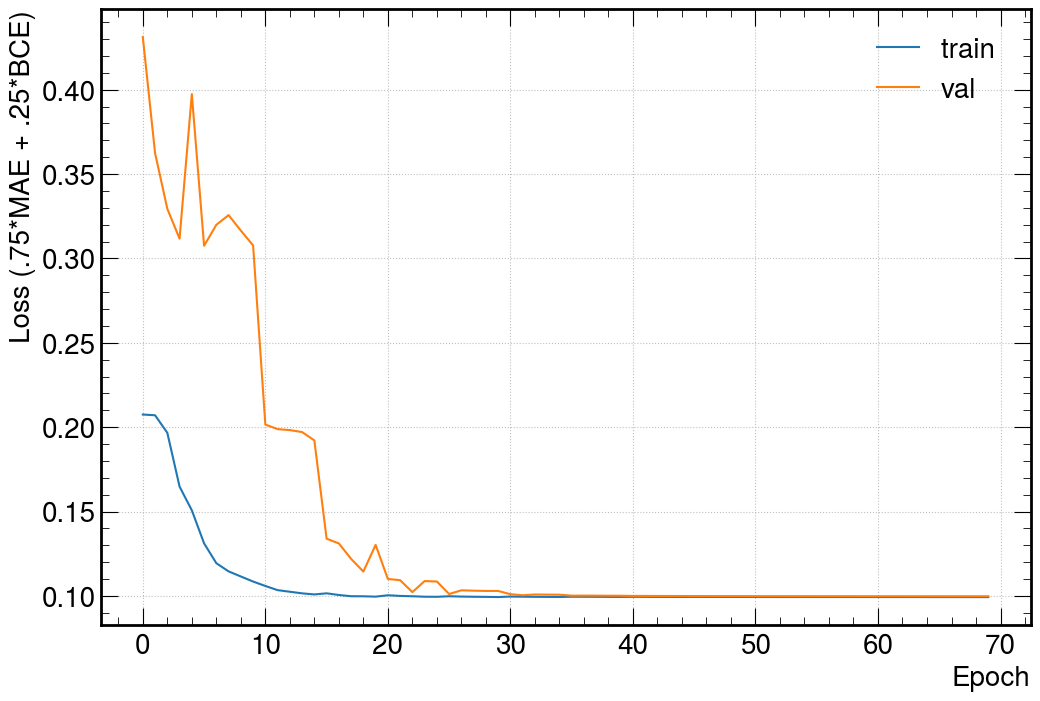

In [5]:
npz_unpacked_loss = np.load(path_to_result + "/losses.npz")

train_loss = npz_unpacked_loss['training']
val_loss = npz_unpacked_loss['validation']

# The losses are recorded for every batch in an epoch
# Average over the batches to get a 
val_mean_loss=np.mean(val_loss, axis = 1)
train_mean_loss=np.mean(train_loss, axis = 1)

figure = plt.figure(figsize=(12,8))
plt.plot(train_mean_loss,label ='train ')

plt.plot(val_mean_loss, label = 'val')
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel(
           "Loss ({regress_weight}*MAE + {class_weight}*BCE)".format(
                                                                      regress_weight=regression_weight,
                                                                      class_weight=classification_weight
                                                                     ),
           fontsize = 20
          )
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.grid()

In [6]:
# Getting energy bins based off target energies
energy_bins = np.unique(np.round(targets_ene).astype(int)) # Returns a sorted array of unique target energies
print(energy_bins)

[ 10  11  12  13  14  16  17  19  21  24  26  29  32  35  39  43  47  52
  57  63  70  77  85  93 103 114 125 138 152 168 185 204 225 248 274 302]


## Extract classification results 

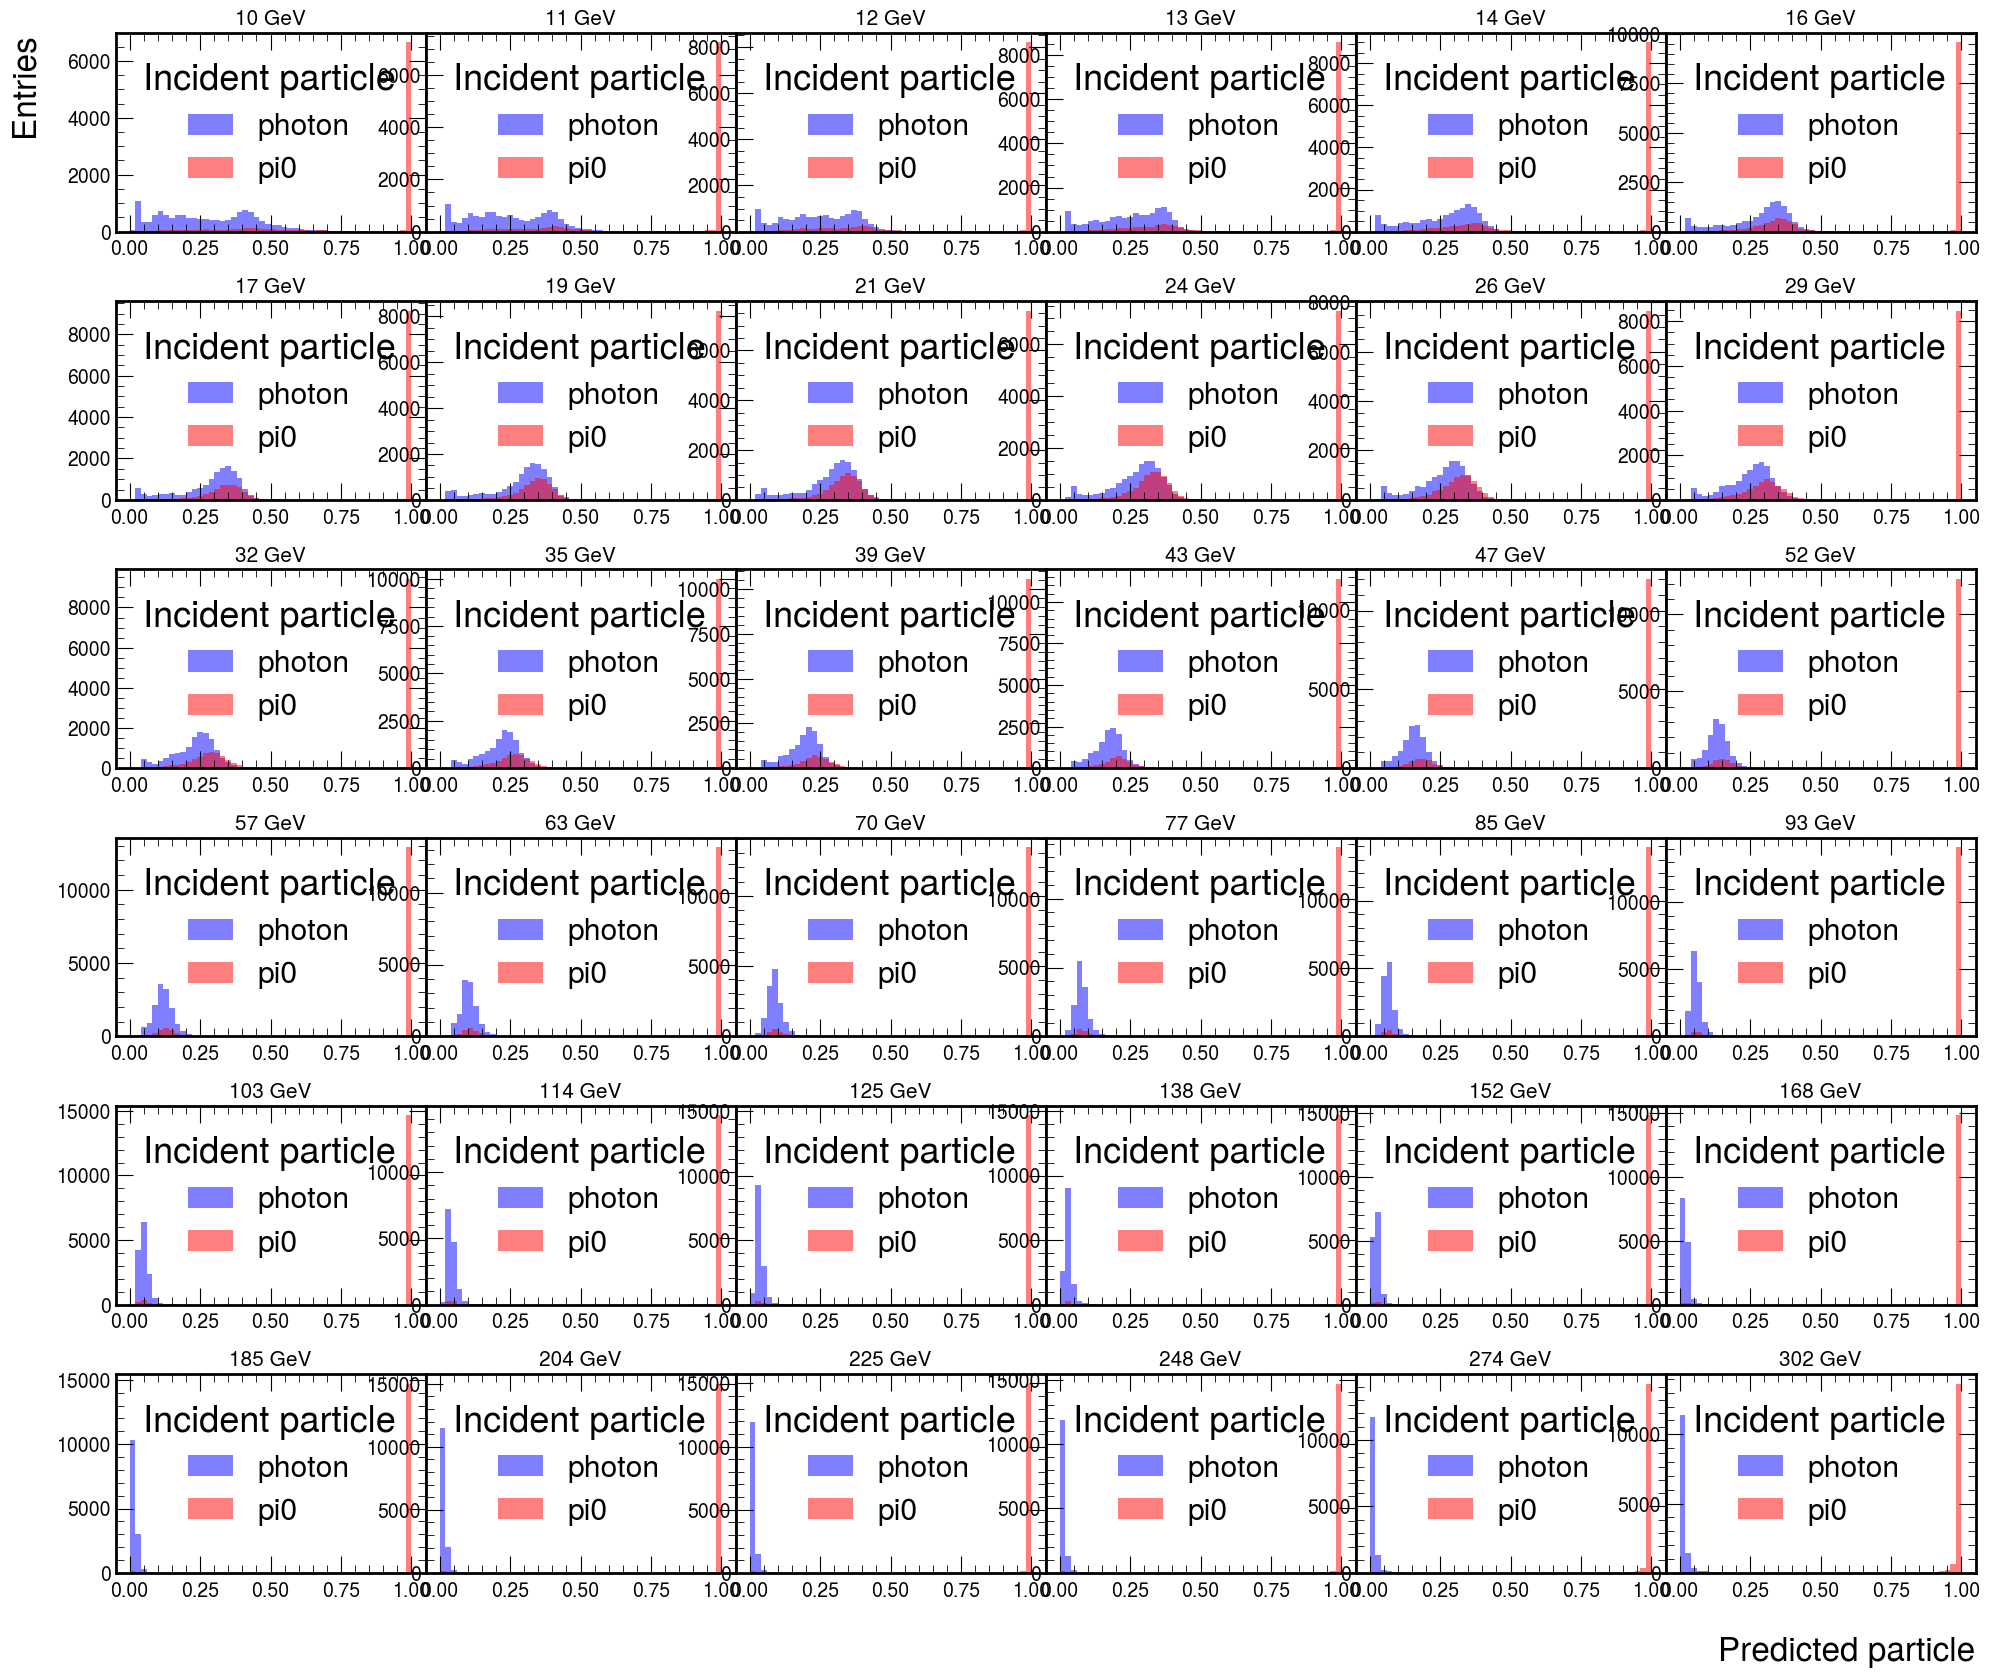

In [7]:
# Plotting the model's predicted values for classification
# The blue (red) are photon (pi0) events
# The model outputs in the range [0, 1]
# Need a cutoff value (id_cut) to say whether the model predicted a pi0 or gamma
# If the model's output is equal to or below id_cut, the prediction is a photon. If above id_cut, it's a pi0 
nbins=50
id_cut = 0.3
photon_accuracy, pi0_accuracy, classification_accuracy,\
photon_misidentification, pi0_misidentification, classification_misidentification = plot_classification(
                                                                             targets_ene,
                                                                             targets_particle,
                                                                             predictions_particle,
                                                                             energy_bins,
                                                                             nbins,
                                                                             id_cut
                                                                             )

## Plotting the model's classification accuracy and efficiency 

In [8]:
# Copies of the results used for the ZDC paper
# These results are for dataset in /home/ryan/zdc_studies/results/pi0_gamma_classifcation_results_regress0.75_class0.25_energy0.5_theta0.5_num1/
photon_accuracy_copy = np.asarray([0.541151, 0.609476, 0.610571, 0.580496, 0.52372 , 0.442948,
       0.420962, 0.423926, 0.456044, 0.548684, 0.615457, 0.725877,
       0.848467, 0.924024, 0.966091, 0.985526, 0.990601, 0.993647,
       0.995297, 0.996323, 0.996472, 0.996616, 0.996722, 0.997569,
       0.996975, 0.997463, 0.997515, 0.997101, 0.996863, 0.997137,
       0.997117, 0.996359, 0.995006, 0.992846, 0.990898, 0.985716])
pi0_misidentification_copy = np.asarray([0.070509, 0.093674, 0.108761, 0.11199 , 0.109508, 0.095728,
       0.098996, 0.105305, 0.125843, 0.159009, 0.179288, 0.20852 ,
       0.233374, 0.25635 , 0.257732, 0.234116, 0.201395, 0.179329,
       0.146239, 0.130307, 0.10346 , 0.08894 , 0.070097, 0.060498,
       0.050006, 0.045752, 0.036144, 0.028828, 0.026024, 0.018129,
       0.019057, 0.014717, 0.013489, 0.011581, 0.010514, 0.011606])
photon_misidentification_copy = np.asarray([0.458849, 0.390524, 0.389429, 0.419504, 0.47628 , 0.557052,
       0.579038, 0.576074, 0.543956, 0.451316, 0.384543, 0.274123,
       0.151533, 0.075976, 0.033909, 0.014474, 0.009399, 0.006353,
       0.004703, 0.003677, 0.003528, 0.003384, 0.003278, 0.002431,
       0.003025, 0.002537, 0.002485, 0.002899, 0.003137, 0.002863,
       0.002883, 0.003641, 0.004994, 0.007154, 0.009102, 0.014284])
pi0_accuracy_copy = np.asarray([0.929491, 0.906326, 0.891239, 0.88801 , 0.890492, 0.904272,
       0.901004, 0.894695, 0.874157, 0.840991, 0.820712, 0.79148 ,
       0.766626, 0.74365 , 0.742268, 0.765884, 0.798605, 0.820671,
       0.853761, 0.869693, 0.89654 , 0.91106 , 0.929903, 0.939502,
       0.949994, 0.954248, 0.963856, 0.971172, 0.973976, 0.981871,
       0.980943, 0.985283, 0.986511, 0.988419, 0.989486, 0.988394])
classification_accuracy_copy = np.asarray([0.69543 , 0.736261, 0.73955 , 0.726586, 0.704371, 0.683527,
       0.671074, 0.670551, 0.675451, 0.70345 , 0.723562, 0.760111,
       0.805304, 0.828794, 0.849152, 0.869459, 0.889643, 0.90355 ,
       0.921495, 0.929836, 0.944248, 0.951863, 0.961633, 0.967319,
       0.972134, 0.974845, 0.979945, 0.983484, 0.984779, 0.989162,
       0.98867 , 0.990554, 0.990546, 0.990523, 0.990161, 0.987116])

# The efficiency when using a simple sigma cut on the energy distributions. Analysis done by Miguel Arratia elsewhere
sigmacut_pi0_energy = [54.3694141, 63.50546177, 73.83316783, 86.94141013, 100.6454816, 100.6454816, 117.3286991,
                     137.388282, 160.8242304, 187.040715, 218.8182721, 255.3624628]
sigmacut_pi0_efficiency = np.asarray([0.1518263496, 0.1205520052, 0.09725460851, 0.06963578404, 0.05398797821,0.05398797821,
                         0.04355447821, 0.03323448447, 0.02767844093, 0.02659931584, 0.02417796191, 0.02398642132])
sigmacut_photon_energy = [54.17080437, 63.50546177, 73.63455809, 86.7428004, 100.8440914, 117.7259186, 138.182721,
                        160.4270109, 187.2393247, 218.8182721, 255.163853]
sigmacut_photon_efficiency = np.asarray([0.9089693155, 0.9533988229, 0.9686861141, 0.9920778849, 0.9842185296, 0.9920778849,
                            0.9920778849, 1., 0.9764214371, 1., 0.9920778849])

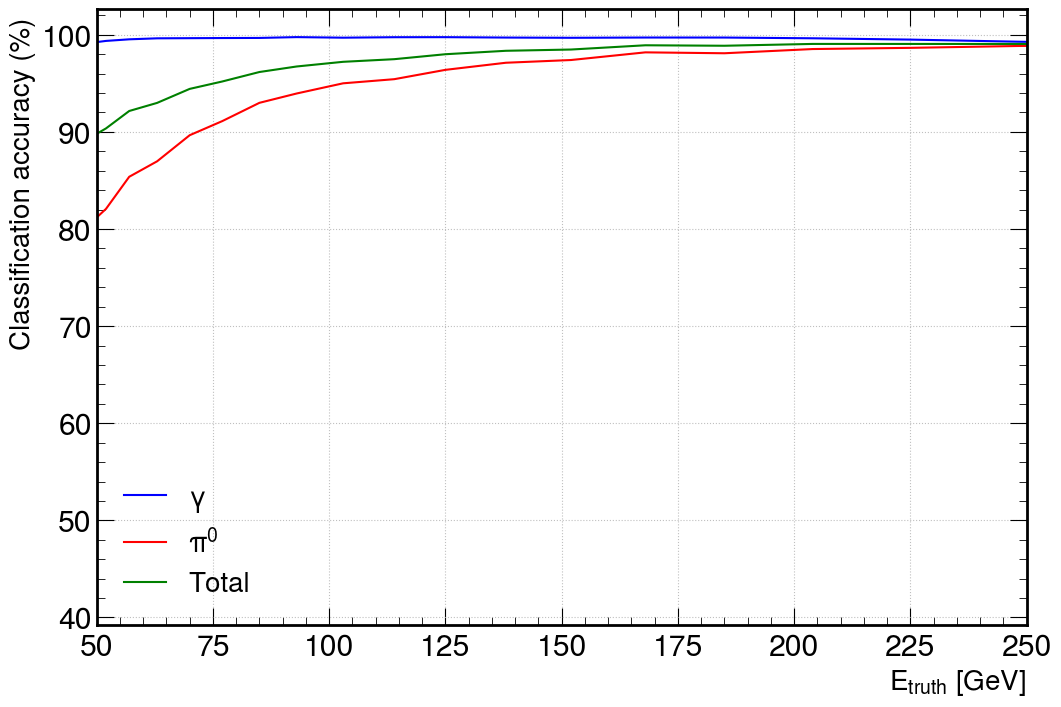

In [9]:
# Model's accuracy of classifying photon (pi0) events as photon (pi0)
hep.style.use("CMS")
fig = plt.figure(figsize = (12,8))
fig.set_facecolor('w')
plt.plot()
plt.plot(energy_bins, photon_accuracy * 100, label = '$\gamma$', color = 'b')
plt.plot(energy_bins, pi0_accuracy * 100, label = '$\pi^0$', color = 'r')
plt.plot(energy_bins, classification_accuracy * 100, label='Total', color = 'g') # Overall accuracy for both photon & pi0


plt.xlabel('$E_{truth}$ [GeV]', fontsize = 20)
# plt.title("ZDC $\pi^0$ & $\gamma$ classification\n" + 'ID cut = {cut}'.format(cut=id_cut))
plt.ylabel('Classification accuracy (%) ',  fontsize = 20)
plt.legend(fontsize="20")
plt.xlim(50,250)
plt.grid()

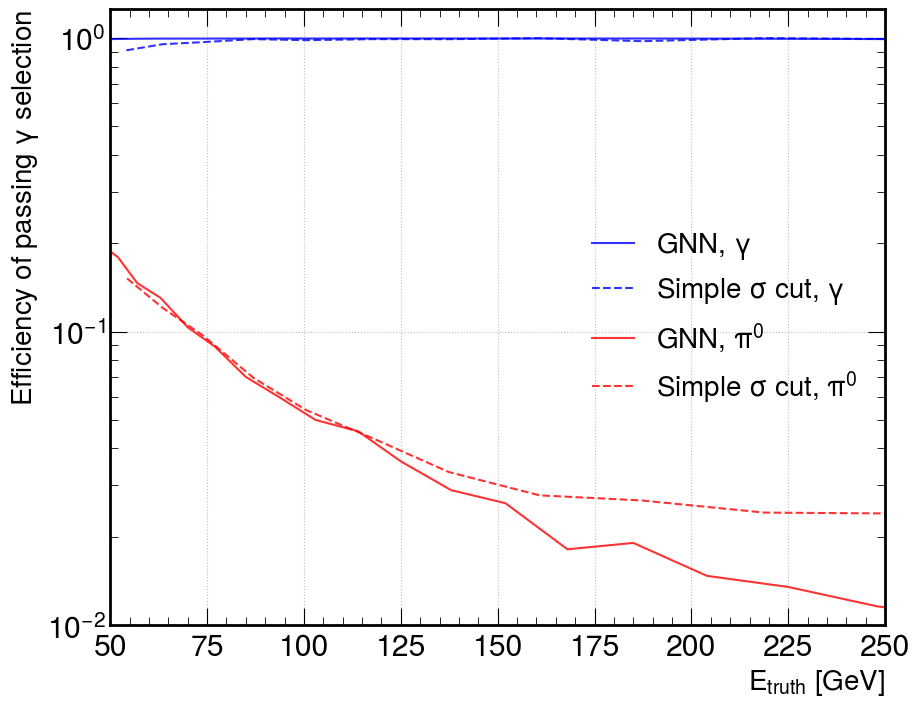

In [10]:
# Model's efficiency for events passing photon cut
# i.e. Fraction of events the model classified photons as photons, pi0 as photons 
fig = plt.figure(figsize=(10,8))
fig.set_facecolor('w')
plt.plot()
plt.plot(energy_bins, photon_accuracy, label='GNN, $\gamma$', color='b', alpha=.8)
plt.plot(
         sigmacut_photon_energy,
         sigmacut_photon_efficiency,
         label='Simple $\sigma$ cut, $\gamma$', 
         color = 'b', 
         linestyle='dashed',
         alpha=.8
        )
plt.plot(energy_bins, pi0_misidentification, label='GNN, $\pi^0$', color='r',alpha=.8)
plt.plot(
         sigmacut_pi0_energy,
         sigmacut_pi0_efficiency,
         label='Simple $\sigma$ cut, $\pi^0$',
         color = 'r',
         linestyle='dashed',
         alpha=.8
        )


plt.yscale("log")
plt.ylim(10**-2,)
plt.xlim(50, 250)
plt.xlabel('$E_{truth}$ [GeV]', fontsize=20)
plt.ylabel('Efficiency of passing $\gamma$ selection', fontsize=20)
plt.legend(fontsize="20")
plt.grid()

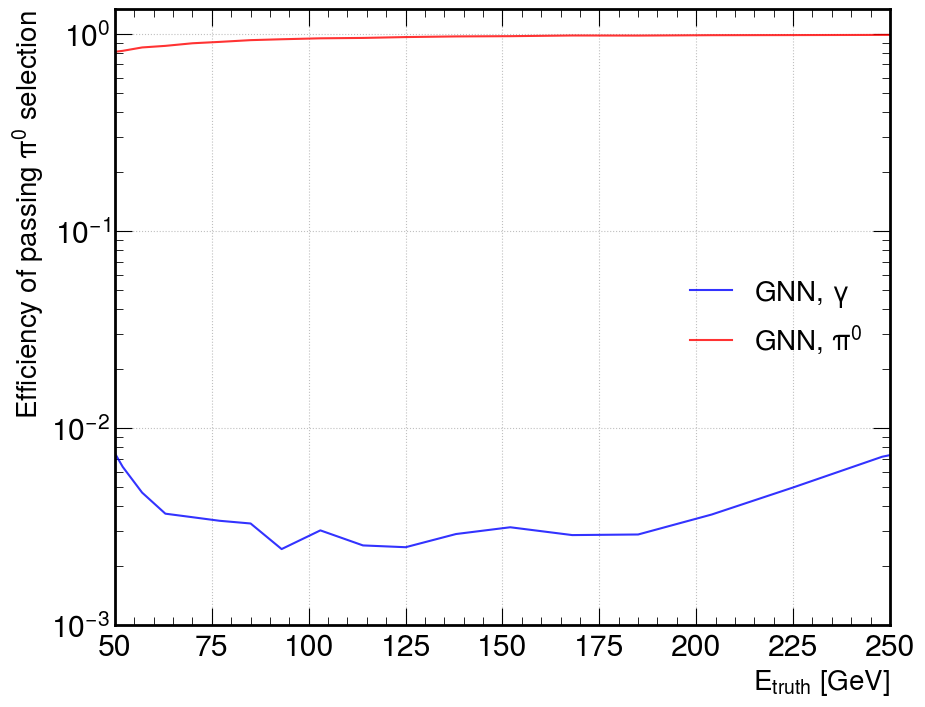

In [11]:
# Model's efficiency for events passing pi0 cut
# i.e. Fraction of events the model classified photons as pi0, pi0 as pi0 

fig = plt.figure(figsize=(10,8))
fig.set_facecolor('w')
plt.plot(energy_bins, photon_misidentification, label='GNN, $\gamma$', color='b',alpha=.8)
plt.plot(energy_bins, pi0_accuracy, label='GNN, $\pi^{0}$', color='r', alpha=.8)


plt.yscale("log")
plt.ylim(10**-3,)
plt.xlim(50, 250)
plt.xlabel('$E_{truth}$ [GeV]', fontsize=20)
plt.ylabel('Efficiency of passing $\pi^{0}$ selection', fontsize=20)
plt.legend(fontsize="20")
plt.grid()

## Show predicted energy distributions for low and high energies 
### Inspecting to try to explain worse efficiency at low energies

Text(0.5, 1.0, '152 GeV')

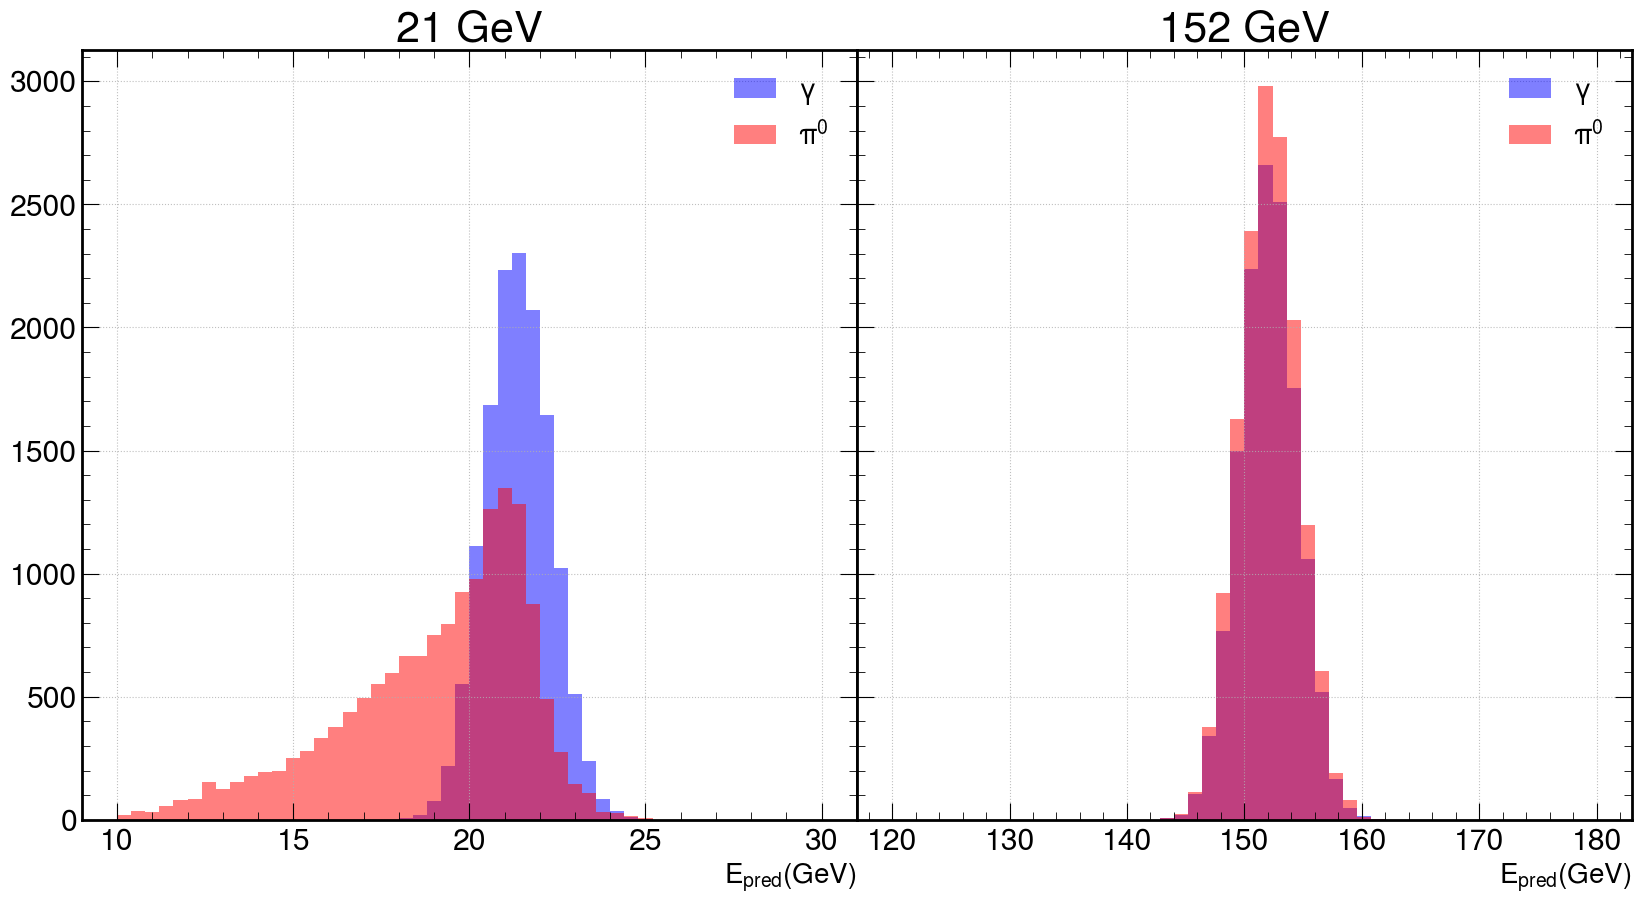

In [12]:
# Plotting low and high energy predicted energies to show the disparity between them and between pi0 and gamma

photon_21GeV_mask = (targets_particle == 0) & (np.round(targets_ene).astype(int) == 21)
photon_21GeV_data =  predictions_ene[photon_21GeV_mask]
pi0_21GeV_mask = (targets_particle == 1) & (np.round(targets_ene).astype(int) == 21)
pi0_21GeV_data = predictions_ene[pi0_21GeV_mask]

photon_152GeV_mask = (targets_particle == 0) & (np.round(targets_ene).astype(int) == 152)
photon_152GeV_data = predictions_ene[photon_152GeV_mask]
pi0_152GeV_mask = (targets_particle == 1) & (np.round(targets_ene).astype(int) == 152)
pi0_152GeV_data = predictions_ene[pi0_152GeV_mask]


fig = plt.figure(figsize=(20, 10))
fig.set_facecolor('w')
gs = fig.add_gridspec(1,2, wspace=0)
axs = gs.subplots(sharex=False, sharey=True)

axs[0].hist(
            photon_21GeV_data,
            50,
            [10, 30],
            alpha = 0.5,
            color = 'b',
            label='$\gamma$'
           )
axs[0].hist(
            pi0_21GeV_data,
            50,
            [10, 30],
            alpha = 0.5,
            color = 'r',
            label='$\pi^{0}$'
           )
axs[0].set_xlabel('$E_{pred} (GeV)$',  fontsize=20)
axs[0].legend(fontsize="20")
axs[0].grid()
axs[0].set_title('21 GeV')

axs[1].hist(
            photon_152GeV_data,
            50,
            [120, 180],
            alpha = 0.5,
            color = 'b',
            label='$\gamma$'
           )
axs[1].hist(
            pi0_152GeV_data,
            50,
            [120, 180],
            alpha = 0.5,
            color = 'r',
            label='$\pi^{0}$'
           )
axs[1].set_xlabel('$E_{pred} (GeV)$',  fontsize=20)
axs[1].legend(fontsize="20")
axs[1].grid()
axs[1].set_title('152 GeV')

## Extract regression results for photon events

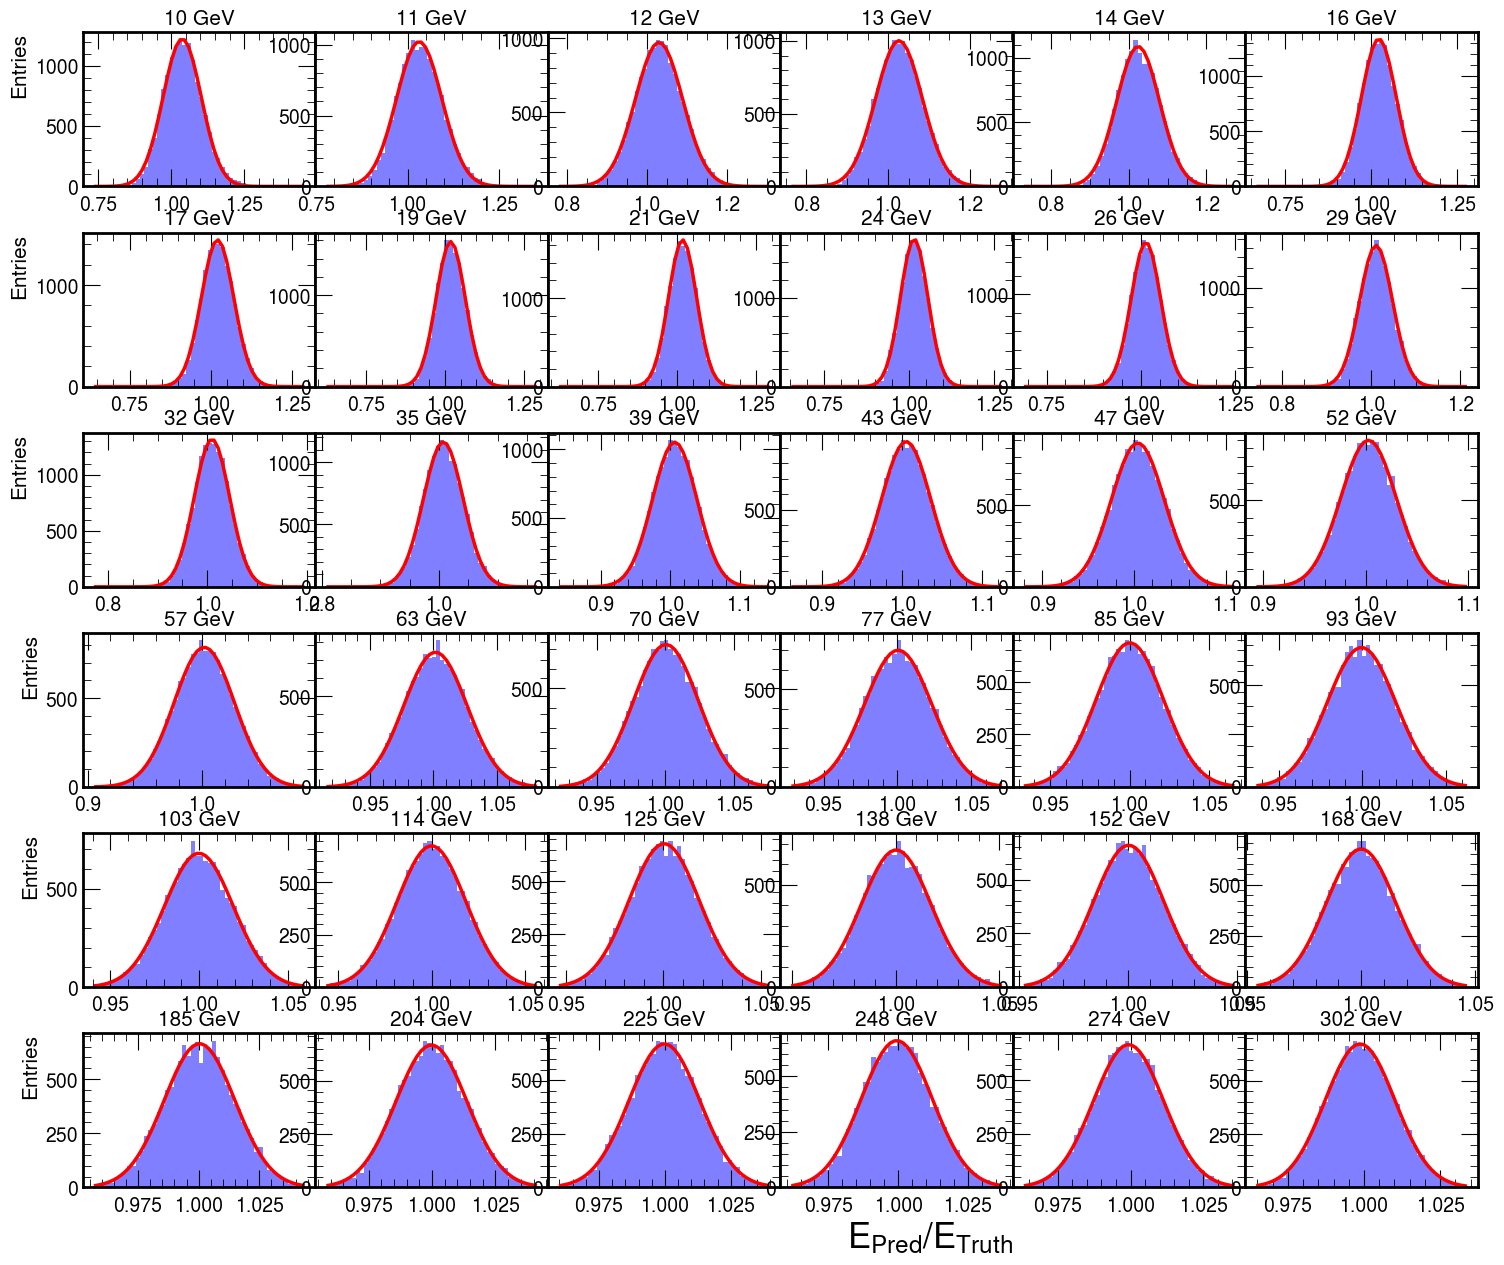

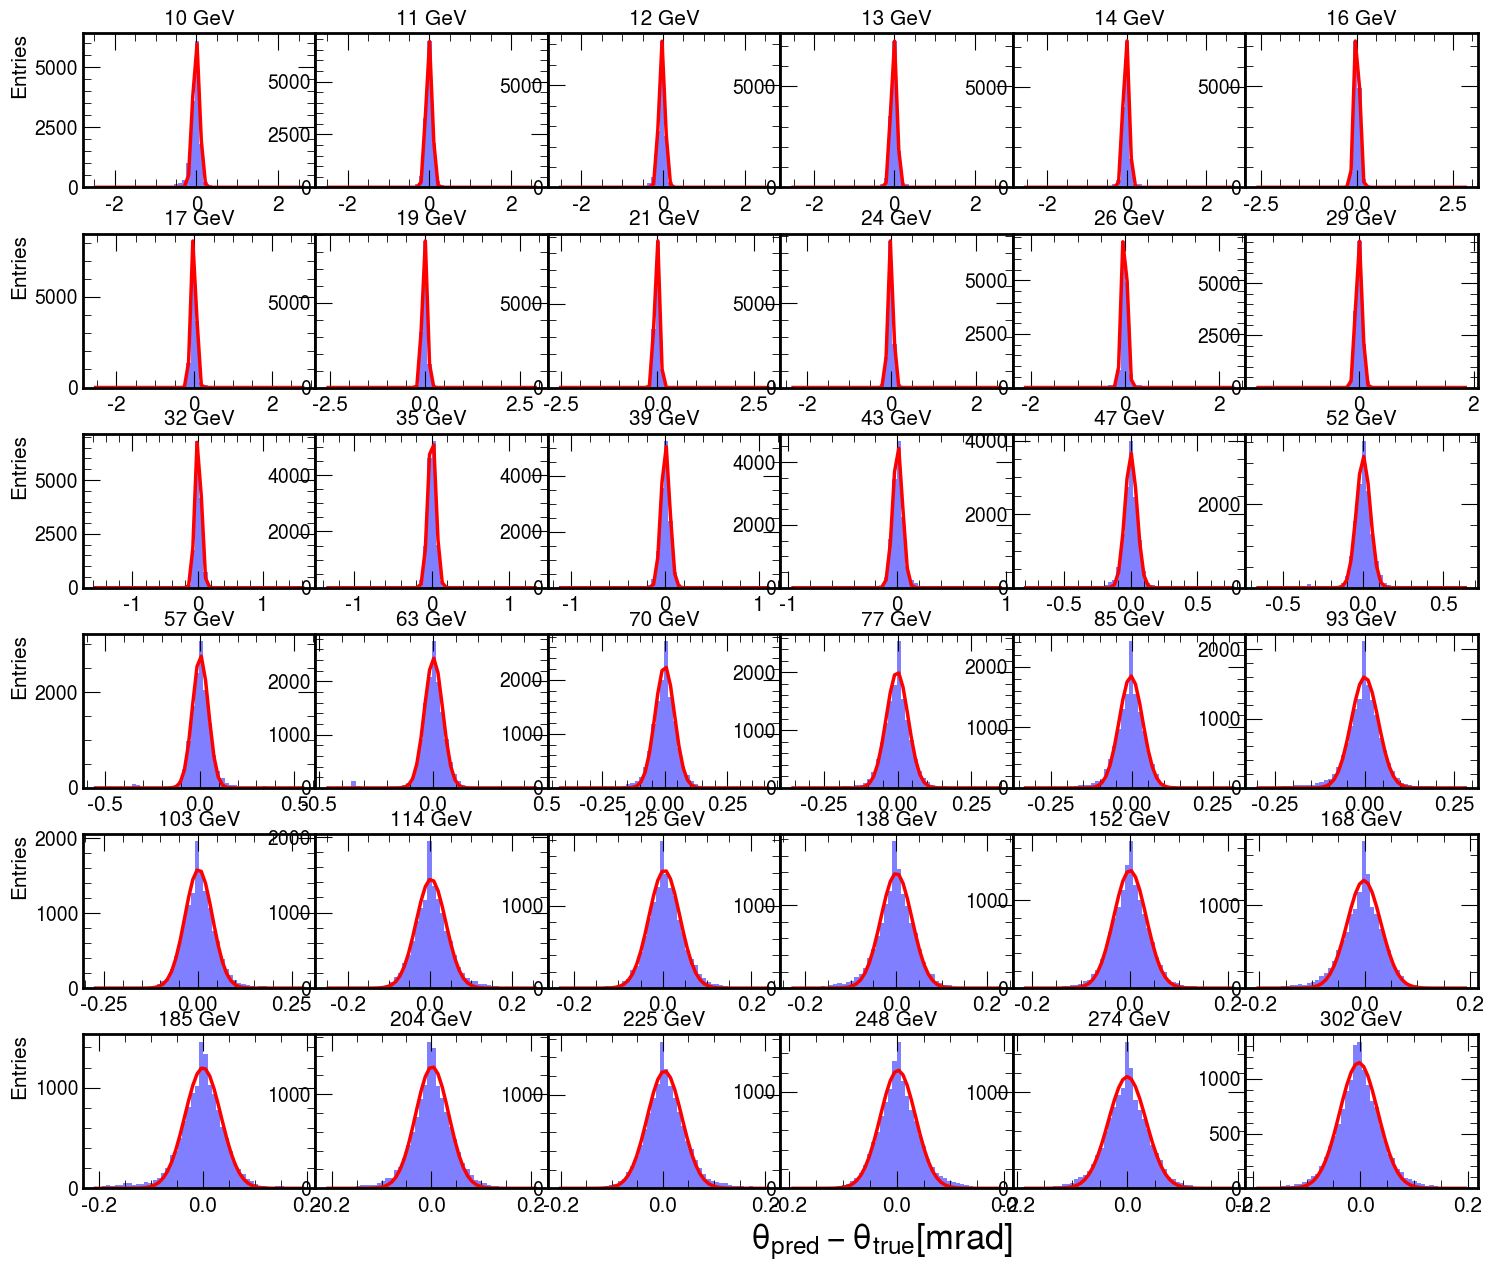

In [13]:
desired_particle_id = 0 # 0 = photons, 1 = pi0
nbins = 50
photon_energy_resolution, photon_energy_scale, photon_true_fit, _, _ = get_res_specific_particle(
                                                                                                 targets_ene,
                                                                                                 predictions_ene,
                                                                                                 targets_particle,
                                                                                                 energy_bins,
                                                                                                 nbins,
                                                                                                 desired_particle_id,
                                                                                                 'energy',
                                                                                                 fit = True,
                                                                                                 plot_range = 3
                                                                                                )
if output_dim=='2D':
    theta_pred_true_difference = predictions_theta - targets_theta
    photon_theta_resolution, _, photon_true_fit_th, _, _ = get_res_specific_particle(
                                                                                     targets_ene,
                                                                                     theta_pred_true_difference,
                                                                                     targets_particle,
                                                                                     energy_bins,
                                                                                     nbins,
                                                                                     desired_particle_id,
                                                                                     'theta-energy',
                                                                                     fit = True,
                                                                                     plot_range = 3
                                                                                    )

In [14]:
# Printing the energy and theta fit parameters from the previous cell
if model=='graphnet':
    approach='gnn_'
elif model=='DeepSets':
    approach='ds_'

particle_detector=f'Input{input_features}_output{output_dim}_{detector}_{absorber}'
name_tag=f'ds_{output_dim}D_output_'
photon_true_fit = np.round(photon_true_fit, 2)    
print('##------------Energy REGRESSION PARAMETERS---------------------------------------')
print_parameter(photon_true_fit, approach +'energy', particle_detector ) 
print_parameter(photon_energy_resolution, approach +'res_fit', particle_detector ) ## sigma over mean fit 
print_parameter(photon_energy_scale, approach +'scale_median', particle_detector )

if output_dim=='2D':
    print('##------------THETA REGRESSION PARAMETERS---------------------------------------')
    print(f'##--Detector = {detector},   Absorber ={absorber },  input = {input_features},  output = {output_dim},\
     Model={model},  ECAL Status={include_ecal}')
    particle_detector=f'Input{input_features}_output{output_dim}_{detector}_{absorber}'
    name_tag=f'ds_{output_dim}D_output_'
    photon_true_fit_th = np.round(photon_true_fit_th, 2)    
    print_parameter(photon_true_fit_th, approach +'energy',particle_detector ) 
    print_parameter(photon_theta_resolution, approach +'theta_res_fit', particle_detector ) ## sigma over mean fit 


##------------Energy REGRESSION PARAMETERS---------------------------------------
gnn_energy_Input4D_output2D_zdc_64Fe=np. array([ 10.,  11.,  12.,  13.,  14.,  16.,  17.,  19.,  21.,  24.,  26.,
        29.,  32.,  35.,  39.,  43.,  47.,  52.,  57.,  63.,  70.,  77.,
        85.,  93., 103., 114., 125., 138., 152., 168., 185., 204., 225.,
       248., 274., 302.])
gnn_res_fit_Input4D_output2D_zdc_64Fe=np. array([0.063023, 0.06002 , 0.057441, 0.055501, 0.053957, 0.049736,
       0.048919, 0.045539, 0.043959, 0.040061, 0.038831, 0.036647,
       0.0353  , 0.033745, 0.031629, 0.030447, 0.028765, 0.027048,
       0.02628 , 0.024866, 0.023594, 0.022748, 0.021262, 0.020523,
       0.019355, 0.018407, 0.0179  , 0.016746, 0.016049, 0.01535 ,
       0.014577, 0.013944, 0.013402, 0.012691, 0.012064, 0.011489])
gnn_scale_median_Input4D_output2D_zdc_64Fe=np. array([1.037776, 1.031746, 1.029732, 1.026626, 1.024341, 1.022971,
       1.021051, 1.018731, 1.017695, 1.014913, 1.013533, 1.01082 ,
      

In [15]:
# Numbers taken from running previous cell
# The numbers below are used in the ZDC paper

##------------Energy REGRESSION PARAMETERS---------------------------------------
# .75 * regression + .25 * classiciation unless stated otherwise in variable name
energy_Input4D_output2D_zdc_64Fe = np. array([ 10.,  11.,  12.,  13.,  14.,  16.,  17.,  19.,  21.,  24.,  26.,
        29.,  32.,  35.,  39.,  43.,  47.,  52.,  57.,  63.,  70.,  77.,
        85.,  93., 103., 114., 125., 138., 152., 168., 185., 204., 225.,
       248., 274., 302.])
photon_energyres_fit_Input4D_output2D_zdc_64Fe_regress75_class25_e5_th5=np. array([0.063023, 0.06002 , 0.057441, 0.055501, 0.053957, 0.049736,
       0.048919, 0.045539, 0.043959, 0.040061, 0.038831, 0.036647,
       0.0353  , 0.033745, 0.031629, 0.030447, 0.028765, 0.027048,
       0.02628 , 0.024866, 0.023594, 0.022748, 0.021262, 0.020523,
       0.019355, 0.018407, 0.0179  , 0.016746, 0.016049, 0.01535 ,
       0.014577, 0.013944, 0.013402, 0.012691, 0.012064, 0.011489])
photon_energyscale_fit_Input4D_output2D_zdc_64Fe_regress75_class25_e5_th5=np. array([1.037776, 1.031746, 1.029732, 1.026626, 1.024341, 1.022971,
       1.021051, 1.018731, 1.017695, 1.014913, 1.013533, 1.01082 ,
       1.009192, 1.00749 , 1.006259, 1.004936, 1.004233, 1.00272 ,
       1.002058, 1.001553, 1.000483, 1.0005  , 1.000114, 0.999608,
       0.999854, 0.999932, 1.000345, 1.000251, 1.00024 , 0.999935,
       1.00035 , 0.999754, 0.999803, 0.999521, 0.999304, 0.998712])

photon_energyres_fit_Input4D_output2D_zdc_64Fe_noclassification_e5_th5=np. array([0.049993, 0.04874 , 0.052308, 0.053076, 0.051727, 0.048587,
       0.047648, 0.04481 , 0.04286 , 0.039501, 0.038375, 0.036257,
       0.034866, 0.033602, 0.031363, 0.030164, 0.028635, 0.026985,
       0.026086, 0.024783, 0.023492, 0.022647, 0.021286, 0.020488,
       0.019271, 0.018309, 0.017914, 0.016706, 0.016056, 0.015337,
       0.014573, 0.013929, 0.013418, 0.012636, 0.011867, 0.01069])

# Strawman energy resolution. Obtained in code near the bottom of the notebook
photon_energyres_fit_Input4D_output2D_zdc_64Fe_strawman=np. array([0.064592, 0.061331, 0.058688, 0.055912, 0.05425 , 0.050501,
       0.049208, 0.046146, 0.044445, 0.04062 , 0.039256, 0.037105,
       0.035586, 0.034257, 0.032154, 0.03109 , 0.029216, 0.027493,
       0.026636, 0.025282, 0.024016, 0.023056, 0.021711, 0.020773,
       0.019517, 0.018572, 0.018103, 0.016857, 0.016124, 0.01546 ,
       0.014749, 0.013973, 0.013446, 0.012735, 0.012085, 0.011412])
photon_energyscale_fit_Input4D_output2D_zdc_64Fe_strawman=np. array([0.997789, 0.998072, 0.99954 , 0.998852, 0.998099, 0.999243,
       0.998638, 0.999076, 0.999738, 1.000192, 1.000324, 0.999825,
       1.000084, 1.000083, 1.000383, 1.000372, 1.000859, 1.000502,
       1.000528, 1.000974, 1.000466, 1.001004, 1.000937, 1.000665,
       1.001095, 1.001144, 1.001509, 1.001482, 1.001468, 1.001188,
       1.001701, 1.001208, 1.001542, 1.00152 , 1.001576, 1.001343])

In [16]:
##------------Theta REGRESSION PARAMETERS---------------------------------------
photon_thetares_fit_Input4D_output2D_zdc_64Fe_regress75_class25_e5_th5=np. array([0.082637, 0.075271, 0.073805, 0.072836, 0.071252, 0.069177,
       0.068143, 0.066628, 0.063402, 0.060162, 0.059489, 0.054604,
       0.048653, 0.050378, 0.045979, 0.044069, 0.044854, 0.04328 ,
       0.042261, 0.039861, 0.038864, 0.037157, 0.036161, 0.037764,
       0.036495, 0.036131, 0.034971, 0.034284, 0.03302 , 0.032029,
       0.034399, 0.033371, 0.033895, 0.032841, 0.033948, 0.035554])

photon_thetares_fit_Input4D_output2D_zdc_64Fe_noclassification_e5_th5=np. array([0.049605, 0.044798, 0.046624, 0.045395, 0.043612, 0.036377,
       0.040752, 0.038221, 0.036807, 0.035735, 0.035709, 0.033979,
       0.02875 , 0.031031, 0.030433, 0.028661, 0.031049, 0.029519,
       0.028003, 0.02607 , 0.025917, 0.024228, 0.022726, 0.025345,
       0.024915, 0.023916, 0.022325, 0.022201, 0.020976, 0.019637,
       0.022884, 0.020937, 0.021611, 0.019351, 0.019896, 0.019177])

# Results produced by Sebouh Paul (UCR postdoc)
baseline_energy=[11.374977633404878, 14.503045598687372, 18.49131826157661, 23.576348065944416, 30.059738319552796, 38.32603189063052, 48.86551921598633, 62.30331840932584, 79.43645226927092, 101.28112129872721, 129.13297659311044, 164.64396750321498, 209.92032206160707, 267.64747158797866]
baseline_th=[0.05584192300287357, 0.051032438205455215, 0.04568372735882933, 0.040359019040363216, 0.03872795432333026, 0.0339092110569593, 0.03129316726201392, 0.028759815747851122, 0.025309529624091446, 0.024113171808801875, 0.02160732147316042, 0.02068087474514293, 0.019447064884239543, 0.017378733836034936]

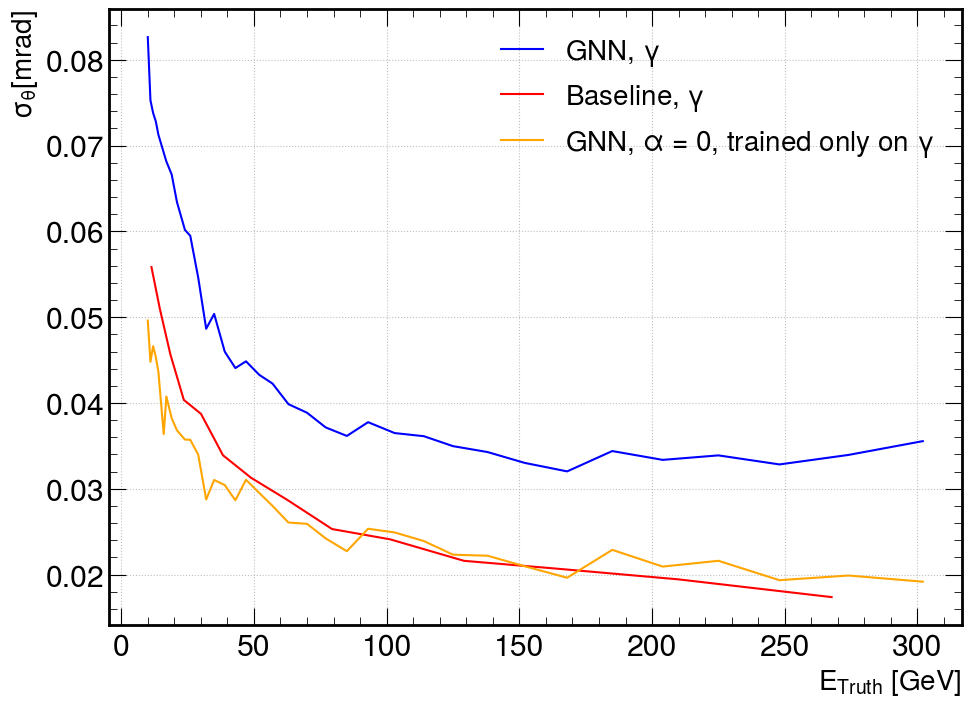

In [17]:
# Plotting only the angular resolutions
fig = plt.figure(figsize=(11, 8))
fig.set_facecolor('w')

plt.plot(
         energy_Input4D_output2D_zdc_64Fe,
         photon_thetares_fit_Input4D_output2D_zdc_64Fe_regress75_class25_e5_th5,
         color='b',
         label='GNN, $\gamma$'
        )
plt.plot(
         baseline_energy,
         baseline_th,
         color='r',
         label='Baseline, $\gamma$'
        )
plt.plot(
         energy_Input4D_output2D_zdc_64Fe,\
         photon_thetares_fit_Input4D_output2D_zdc_64Fe_noclassification_e5_th5,\
         color='orange',\
         label='GNN, $\\alpha$ = 0, trained only on $\gamma$'
        )
plt.xlabel('$E_{Truth}$ [GeV]', fontsize=20)
plt.ylabel('$\sigma_{\\theta} [mrad]$', fontsize=20)

plt.legend(fontsize="20")
plt.grid()

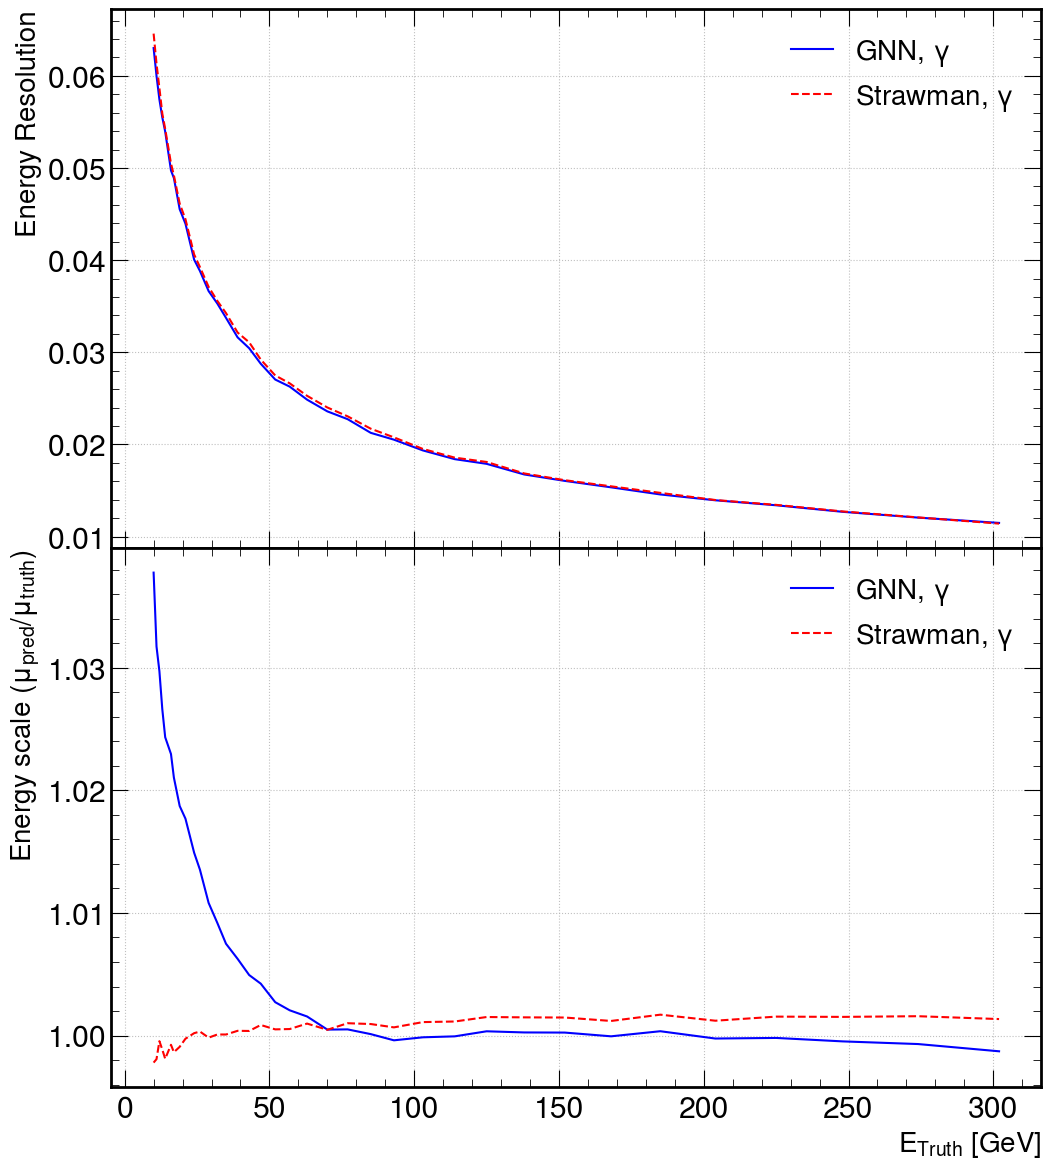

In [18]:
# Comparing the energy resolution and energy scale to those obtained from the strawman method
# Strawman results are obtained in the cells below
fig = plt.figure(figsize=(12,14))
fig.set_facecolor('w')
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
axs[0].errorbar(
                energy_Input4D_output2D_zdc_64Fe,
                photon_energyres_fit_Input4D_output2D_zdc_64Fe_regress75_class25_e5_th5,
                color='b',
                label='GNN, $\gamma$'
               )
axs[0].errorbar(
                energy_Input4D_output2D_zdc_64Fe,
                photon_energyres_fit_Input4D_output2D_zdc_64Fe_strawman,
                color='r',
                linestyle='dashed',
                label='Strawman, $\gamma$'
               )
    
axs[1].errorbar(
                energy_Input4D_output2D_zdc_64Fe,
                photon_energyscale_fit_Input4D_output2D_zdc_64Fe_regress75_class25_e5_th5,
                color='b',
                label='GNN, $\gamma$'
               )
axs[1].errorbar(
                energy_Input4D_output2D_zdc_64Fe,
                photon_energyscale_fit_Input4D_output2D_zdc_64Fe_strawman,
                color='r',
                linestyle='dashed',
                label='Strawman, $\gamma$'
               )


plt.xlabel('$E_{Truth}$ [GeV]', fontsize=20)
axs[0].set_ylabel('Energy Resolution',  fontsize=20)
axs[1].set_ylabel('Energy scale ($\mu_{pred}/\mu_{truth}$)',  fontsize=20)
axs[0].legend(fontsize="20")
axs[1].legend(fontsize="20")
axs[0].grid()
axs[1].grid()

### Getting strawman resolutions for photons

In [19]:
# Grabbing some photon information
photon_mask = targets_particle == 0
predicted_energies_photon = predictions_ene[photon_mask]
target_energies_photon = targets_ene[photon_mask]
meta_info_photon = meta_info[photon_mask]

In [20]:
photon_data = '/media/miguel/Elements/zdc_data/zdc_gamma_log10discrete_10_300GeV_0-0.23deg_staggered_h4_11_23/'

combined_genP, combined_thetas, combined_cluster_sums_hcal,  combined_cluster_sums_ecal, combined_total_energy=\
read_root_files_chain(photon_data, 'zdc', 0, 99, include_ecal)

Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. ==  5000
Total Entries. =

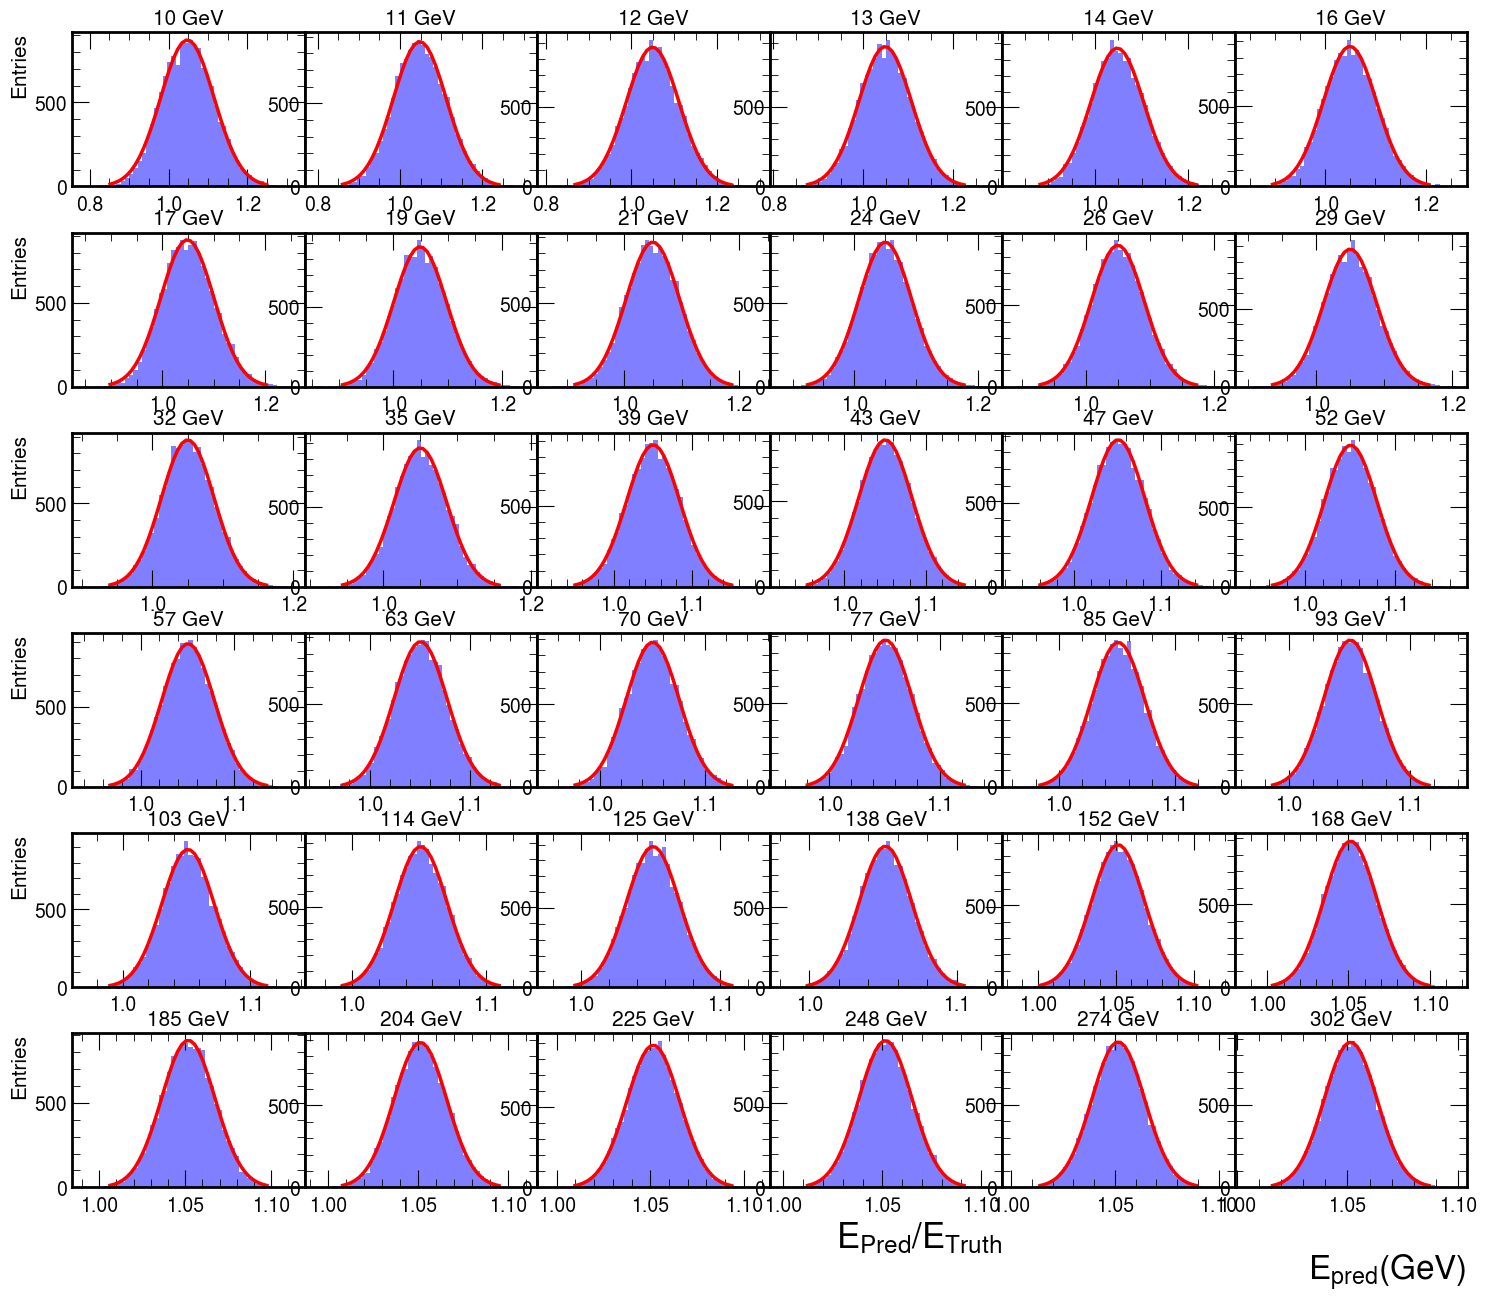

In [21]:
# Getting strawman resolution for discrete photon data
resolution_fit, pred_over_truth_fit, true_fit,\
slices_fit,slices_pred_truth = get_res_scale_fit_log10_log2(\
                                                            combined_genP,\
                                                            combined_total_energy,\
                                                            energy_bins,\
                                                            nbins,\
                                                            'discrete',\
                                                            'gamma',\
                                                            'energy',\
                                                            fit=True,\
                                                            plot_range=4)

In [22]:
if model=='graphnet':
    approach='gnn_'
elif model=='DeepSets':
    approach='ds_'

particle_detector=f'Input{input_features}_output{output_dim}_{detector}_{absorber}'
name_tag=f'ds_{output_dim}D_output_'
particle='pp'

true_fit=np.round(true_fit, 2)    
print('##------------Energy REGRESSION PARAMETERS---------------------------------------')
print(f'##--Detector = {detector},   Absorber ={absorber },  input = {input_features},  output = {output_dim},\
     Model={model},  ECAL Status={include_ecal}')
print_parameter(true_fit, approach +'energy',particle_detector ) 
print_parameter(resolution_fit, approach +'res_fit', particle_detector ) ## sigma over mean fit 
print_parameter(pred_over_truth_fit, approach +'scale_median', particle_detector )


##------------Energy REGRESSION PARAMETERS---------------------------------------
##--Detector = zdc,   Absorber =64Fe,  input = 4D,  output = 2D,     Model=graphnet,  ECAL Status=False
gnn_energy_Input4D_output2D_zdc_64Fe=np. array([ 10.,  11.,  12.,  13.,  14.,  16.,  17.,  19.,  21.,  24.,  26.,
        29.,  32.,  35.,  39.,  43.,  47.,  52.,  57.,  63.,  70.,  77.,
        85.,  93., 103., 114., 125., 138., 152., 168., 185., 204., 225.,
       248., 274., 302.])
gnn_res_fit_Input4D_output2D_zdc_64Fe=np. array([0.064592, 0.061331, 0.058688, 0.055912, 0.05425 , 0.050501,
       0.049208, 0.046146, 0.044445, 0.04062 , 0.039256, 0.037105,
       0.035586, 0.034257, 0.032154, 0.03109 , 0.029216, 0.027493,
       0.026636, 0.025282, 0.024016, 0.023056, 0.021711, 0.020773,
       0.019517, 0.018572, 0.018103, 0.016857, 0.016124, 0.01546 ,
       0.014749, 0.013973, 0.013446, 0.012735, 0.012085, 0.011412])
gnn_scale_median_Input4D_output2D_zdc_64Fe=np. array([1.047678, 1.047975, 1.049517,

### Inspecting pi0 events
### Plotting how many photons from the pi0->2photon decay make it to the ZDC 

In [23]:
pi0_data = '/media/miguel/Elements/zdc_data/zdc_pi0_log10discrete_10GeV-300GeV_0.0deg-0.23deg_staggered_h4_11_19_23/'

pi0_combined_genP, pi0_combined_thetas, pi0_num_good_photons, pi0_total_energy =\
read_pi0_files_chain(pi0_data, 0, 70)

Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. ==  8000
Total Entries. =

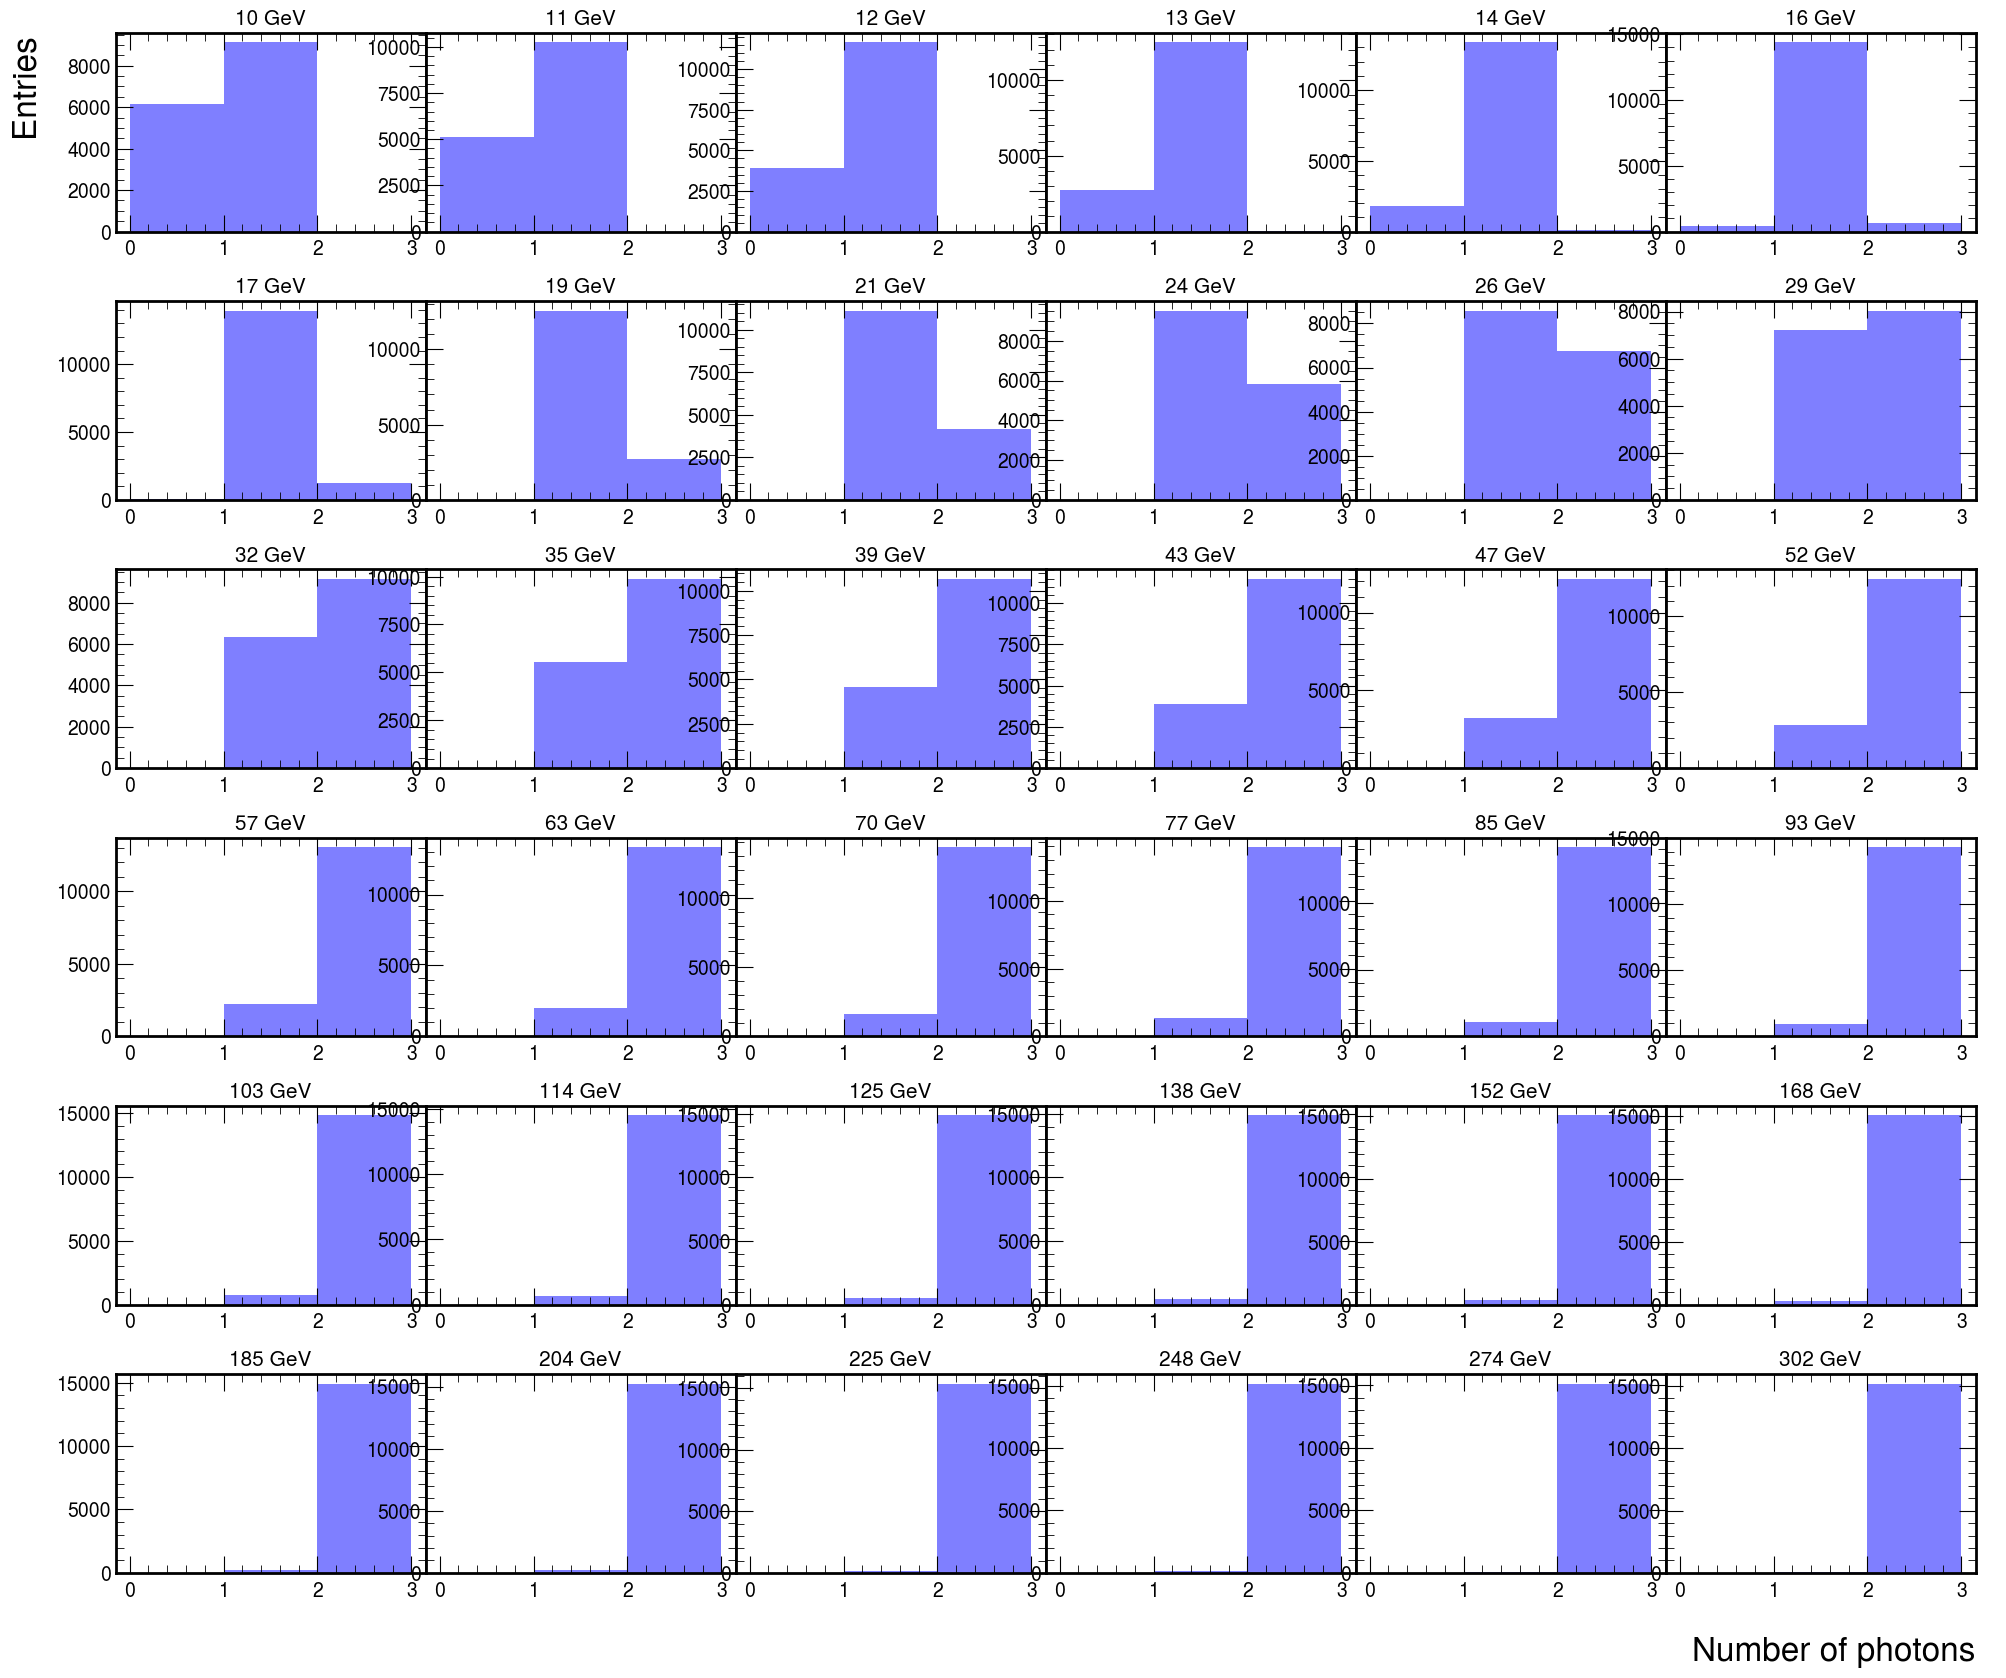

In [24]:
fraction_two_photon_events, fraction_one_photon_events, fraction_zero_photon_events =\
plot_num_photons(pi0_combined_genP, pi0_num_good_photons, energy_bins)

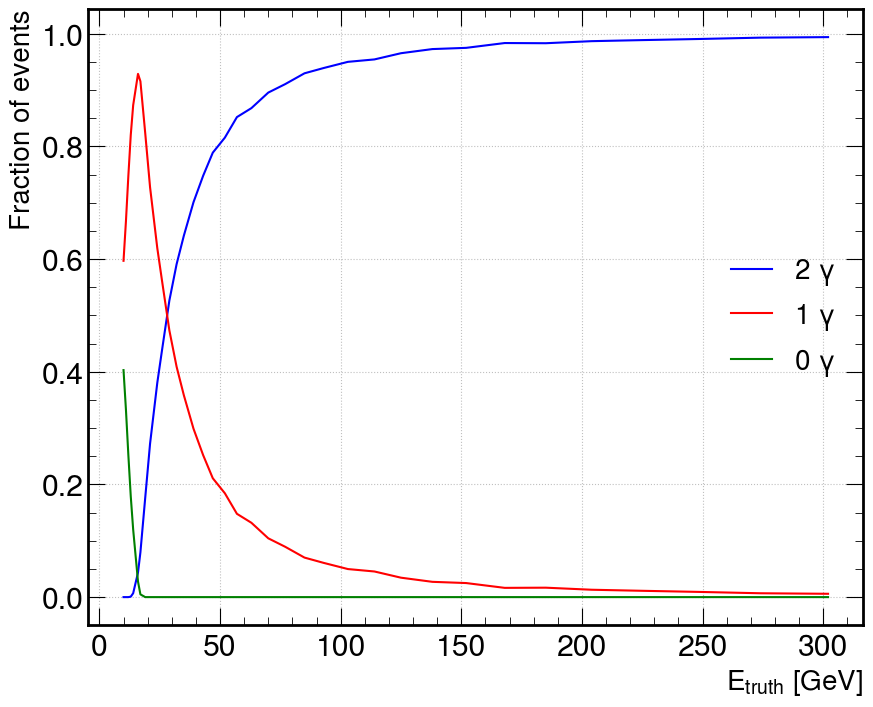

In [25]:
hep.style.use("CMS")
fig = plt.figure(figsize=(10,8))
fig.set_facecolor('w')
plt.plot(energy_bins, fraction_two_photon_events, color='b', label = '2 $\gamma$')
plt.plot(energy_bins, fraction_one_photon_events, color='r', label = '1 $\gamma$')
plt.plot(energy_bins, fraction_zero_photon_events, color='g', label = '0 $\gamma$')

plt.xlabel('$E_{truth}$ [GeV]', fontsize=20)
plt.ylabel('Fraction of events',  fontsize=20)
plt.legend(fontsize="20")
plt.grid()

In [26]:
# Numbers from ZDC paper
fraction_zero_photon_events_copy=[0.402997, 0.33303 , 0.252503, 0.178931, 0.119919, 0.027634,
       0.004858, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.]
fraction_one_photon_events_copy=[0.597003, 0.66697 , 0.747497, 0.82028 , 0.873219, 0.928848,
           0.915644, 0.823387, 0.727606, 0.619451, 0.560366, 0.473477,
           0.408982, 0.358437, 0.298994, 0.252053, 0.211001, 0.184357,
           0.147873, 0.131963, 0.104359, 0.089349, 0.070152, 0.060707,
           0.049801, 0.04549 , 0.034474, 0.02713 , 0.024955, 0.016412,
           0.016738, 0.013088, 0.011202, 0.009277, 0.006834, 0.00589]
fraction_two_photon_events_copy=[0.000000e+00, 0.000000e+00, 0.000000e+00, 7.891103e-04,
       6.861848e-03, 4.351756e-02, 7.949846e-02, 1.766132e-01,
       2.723942e-01, 3.805494e-01, 4.396343e-01, 5.265226e-01,
       5.910176e-01, 6.415633e-01, 7.010059e-01, 7.479473e-01,
       7.889992e-01, 8.156428e-01, 8.521274e-01, 8.680375e-01,
       8.956408e-01, 9.106514e-01, 9.298476e-01, 9.392927e-01,
       9.501987e-01, 9.545095e-01, 9.655262e-01, 9.728705e-01,
       9.750454e-01, 9.835883e-01, 9.832619e-01, 9.869120e-01,
       9.887980e-01, 9.907232e-01, 9.931660e-01, 9.941096e-01]

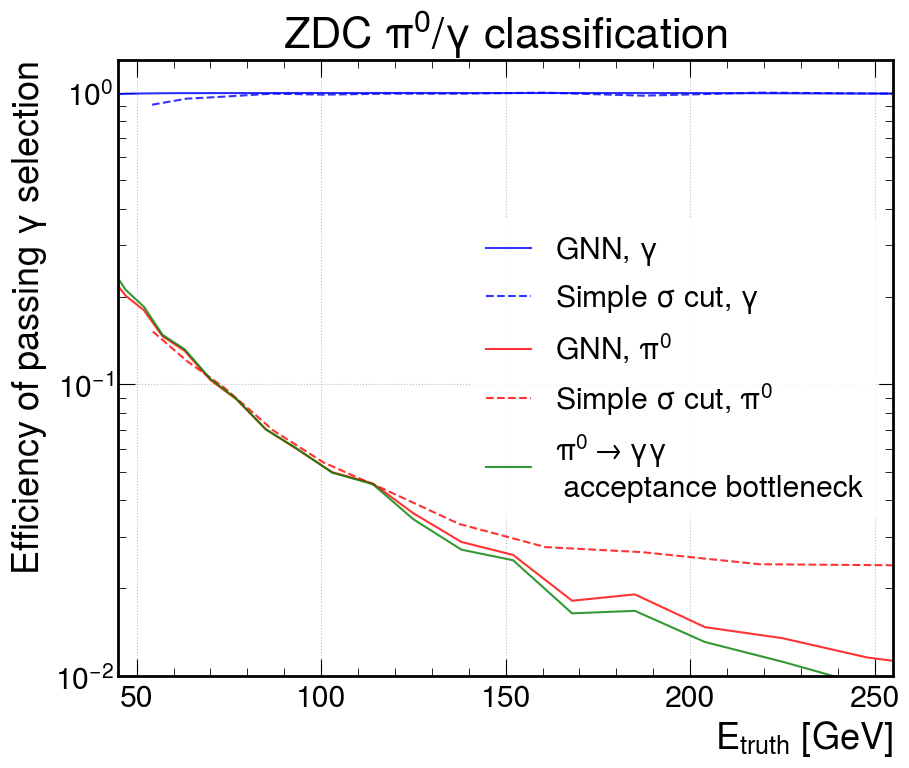

In [27]:
# Main paper plot
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
plt.rcParams['legend.frameon']=True
plt.rcParams['legend.edgecolor']='white'
plt.rcParams["figure.figsize"] = (10, 8)


plt.xlabel('$E_{truth}$ [GeV]')
plt.ylabel('Efficiency of passing $\gamma$ selection', color='black')
plt.plot(energy_bins, photon_accuracy, label='GNN, $\gamma$', color='b', alpha=.8)
plt.plot(sigmacut_photon_energy, sigmacut_photon_efficiency, label='Simple $\sigma$ cut, $\gamma$', color = 'b', linestyle='dashed',alpha=.8)
plt.plot(energy_bins, pi0_misidentification, label='GNN, $\pi^0$', color='r',alpha=.8)
plt.plot(sigmacut_pi0_energy, sigmacut_pi0_efficiency, label='Simple $\sigma$ cut, $\pi^0$', color = 'r', linestyle='dashed',alpha=.8)
plt.plot(energy_bins, fraction_one_photon_events, label=r'$\pi^0 \rightarrow \gamma\gamma$'"\n acceptance bottleneck", color='g',alpha=.8)
plt.yscale("log")
plt.ylim(10**-2,)
plt.xlim(45,255)
plt.legend()
plt.grid()
plt.title("ZDC $\pi^0/\gamma$ classification")
plt.show()